In [88]:
from tqdm import tqdm
from datetime import datetime
import pandas as pd
class Strategy():
    def __init__(self):
        self.idx = None
        self.ohlc = None
        self.indicators = {}
        self._broker = Broker()
        self._positions = {}

    def buy(self,ticker,size=1):
        self._broker.orders.append(
            Order(
                ticker = ticker,
                side = 'buy',
                size = size,
                idx = self.idx
            ))
                
    def sell(self,ticker,size=1):
        self._broker.orders.append(
            Order(
                ticker = ticker,
                side = 'sell',
                size = -size,
                idx = self.idx
            ))


    def position_size(self,ticker):
        return self._positions[ticker]
    
    def indicator(self, ticker, name):
        return self.indicators[ticker][name].loc[:self.idx]
    
    @property
    def tickers(self):
        return list(self.ohlc.keys())
    def next(self):
        pass
    
class Order():
    def __init__(self, ticker, size, side, idx):
        self.ticker = ticker
        self.side = side
        self.size = size
        self.type = 'market'
        self.idx = idx
        
class Trade():
    def __init__(self, ticker,side,size,price,type,idx):
        self.ticker = ticker
        self.side = side
        self.price = price
        self.size = size
        self.type = type
        self.idx = idx

    
    def __repr__(self):
        return f'<Trade: {self.idx} {self.ticker} {self.size}@{self.price}>'
        
    def __str__(self):
        return f'<Trade: {self.idx} {self.ticker} {self.size}@{self.price}>'
    
class Broker():
    def __init__(self):
        self.orders = []
        self.trades = []

class Engine():
    def __init__(self, strategy:Strategy, cash:float=10_000):
        self.strategy = strategy()
        self.ohlc = {}
        self._iterators = {}
        self.current_prices = {}
        self.current_indicators = {}
        self.indexes = None
        self.cash = cash
        self.cash_series = {}
        self.output = {}
        self.indicator_functions = {}
    
    def set_cash(self, amount:float):
        self.cash = amount

    def add_ohlc(self, name, data):
        self.ohlc[name] = data
        self._iterators[name] = data.iterrows()
        if self.indexes is None:
            self.indexes = data.index.to_numpy()
            
    def add_indicator(self, name, function, *args):
        self.indicator_functions[name] = [function,*args]
        
    def run(self):
        self.strategy.ohlc = self.ohlc
        self._prepare_indicators()
        for t in self.strategy.tickers:
            self.strategy._positions[t] = 0
        for i in tqdm(self.indexes):
            for t in self.strategy.tickers:
                self.current_prices[t] = next(self._iterators[t])[1]
                
            self.strategy.idx = i
            self._fill_orders()
            self.cash_series[i] = self.cash 
            self.strategy.next()
        
        self._prepare_output()
        return self.output
    
    def _prepare_indicators(self):
        for ticker in self.strategy.tickers:
            self.strategy.indicators[ticker] = {}
            for name, logic in self.indicator_functions.items():
                self.strategy.indicators[ticker][name] = logic[0](self.strategy.ohlc[ticker], logic[1])
                
    def _prepare_output(self):
        self.cash_series = pd.Series(self.cash_series)
        df_trades = pd.DataFrame(index=self.cash_series .index)
        for t in self.strategy._broker.trades:
            df_trades.loc[t.idx, t.ticker] = t.size
        df_positions = df_trades.fillna(0).cumsum()

        prices = pd.DataFrame(index=self.cash_series.index)
        for ticker in self.strategy.tickers:
            prices[ticker] = self.strategy.ohlc[ticker]['Close']
        df_portfolio = df_positions * prices
        df_portfolio['cash'] = self.cash_series
        df_portfolio['total'] = df_portfolio.sum(axis=1)
        self.output['portfolio'] = df_portfolio
        self.output['positions'] = df_positions
        self.output['trades'] = df_trades
        
        p = df_portfolio.total
    
    def _fill_orders(self):
        for order in self.strategy._broker.orders:
            can_fill = False
            if order.side == 'buy' and self.cash >= self.current_prices[order.ticker]['Open'] * order.size:
                    can_fill = True 
            elif order.side == 'sell' and self.strategy._positions[order.ticker] >= order.size:
                    can_fill = True
            if can_fill:
                t = Trade(
                    ticker = order.ticker,
                    side = order.side,
                    price= self.current_prices[order.ticker]['Open'],  # self.strategy.ohlc[order.ticker].loc[order.idx, 'Open'],
                    size = order.size,
                    type = order.type,
                    idx = self.strategy.idx)
                self.strategy._positions[order.ticker] += order.size
                self.strategy._broker.trades.append(t)
                self.cash -= t.price * t.size
        self.strategy._broker.orders = []
        

                

In [89]:
import pandas_ta as ta
def sma(ohlc,*params):
    lookback = params[0]
    return ta.sma(ohlc.Close, length=lookback)


class MyStrategy(Strategy):
    count = 0
    def next(self):
        for ticker in self.tickers:
            if self.count == 0:
                if self.position_size(ticker) == 0:
                    self.buy(ticker, 1)
                else:
                    self.sell(ticker, 1)
            if self.count == 5:
                self.count = 0
        self.count += 1
        

class SMAStrategy(Strategy):
    count = 0
    def next(self):
        for ticker in self.tickers:
            if self.position_size(ticker) == 0:
                if self.indicator(ticker, 'sma12')[-1] > self.indicator(ticker,'sma24')[-1]:                
                    self.buy(ticker, 10)
            else:
                if self.indicator(ticker, 'sma12')[-1] < self.indicator(ticker, 'sma24')[-1]:
                    self.sell(ticker, 10)


In [92]:
import yfinance as yf
import pandas_ta as ta
aapl = yf.Ticker('AAPL').history(period='10y')
amzn = yf.Ticker('AMZN').history(period='10y')

e = Engine(SMAStrategy)
e.add_ohlc('AAPL', aapl)
e.add_ohlc('AMZN', amzn)
e.add_indicator('sma12', sma,12)
e.add_indicator('sma24', sma,24)



In [99]:
# output = e.run()
p = output['portfolio'].total
output.keys()

dict_keys(['portfolio', 'positions', 'trades'])

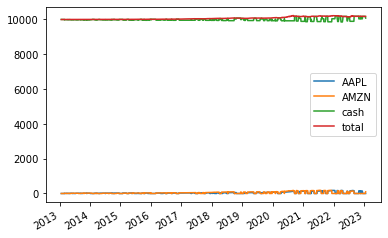

In [101]:
output['portfolio'].plot()

In [102]:
import numpy as np
risk_free_rate = 0
statistics = pd.DataFrame(index=['return_ann', 'volatility_ann'])
statistics.loc['return_ann','value'] = ((p.iloc[-1] / p.iloc[0]) ** (1 / ((p.index[-1] - p.index[0]).days / 365)) -1) * 100
statistics.loc['volatility_ann', 'value'] = p.pct_change().std() *  np.sqrt(252) * 100
statistics.loc['sharpe_ratio', 'value'] = (statistics.value.return_ann - risk_free_rate) / statistics.value.volatility_ann

statistics


,value
return_ann,0.174679
volatility_ann,0.334178
sharpe_ratio,0.522712


In [34]:
e.strategy.indicators['AAPL']['sma'].loc[:e.strategy.idx]

Date
2022-01-18   NaN
Name: SMA_20, dtype: float64

In [124]:
start_date = p.index[0]
end_date = p.index[-1]
duration = (end_date - start_date).days
return_total = (p.iloc[-1] / p.iloc[0]) - 1
exposure = (1 - output['portfolio'].cash / output['portfolio'].total).mean() * 100




-0.007440232597689667

In [61]:
def arg_printer(*args, **kwargs):
   print(args)
   print(type(kwargs))
arg_printer(1, param1=5, param2=6)

(1,)
<class 'dict'>
